# Case Study 3: HIV Viral Load — New vs Standard Therapy

**Bilingual overview | 双语概览**

- **Design 设计**: Independent two-group comparison (Standard vs New therapy). 独立两组比较（标准疗法 vs 新疗法）。
- **Outcome 结局**: Viral load (copies/mL). 病毒载量（拷贝数/毫升）。
- **Goal 目标**: Test whether the distributions (or means) differ between groups. 检验两组分布（或均值）是否存在差异。

**Recommended analysis 建议分析**
1. Primary: Mann–Whitney U (Wilcoxon rank-sum) test — non-parametric. 主要：Mann–Whitney U（Wilcoxon 秩和）非参数检验。
2. Secondary: Welch's t-test as a robustness check. 次要：Welch t 检验作为稳健性参考。
3. Effect sizes: Cliff's delta (非参效应量) + Hedges' g (均值差效应量)。
4. Visualization: Boxplot + jitter, Violinplot (use log–y due to skew). 可视化：箱线图+抖动点、小提琴图（因偏态使用对数坐标）。


## 1) Load data 读取数据
This will try typical paths; if not found, please set `DATA_PATH` manually. 将尝试常见路径；若未找到，请手动设置 `DATA_PATH`。

In [1]:
import pandas as pd, numpy as np, os
from pathlib import Path

CANDIDATE_PATHS = [
    'week6_data_CS3.txt',                # current working dir
    '/mnt/data/week6_data_CS3.txt'      # ChatGPT sandbox path (if running here)
]
DATA_PATH = None
for p in CANDIDATE_PATHS:
    if Path(p).exists():
        DATA_PATH = p
        break
if DATA_PATH is None:
    raise FileNotFoundError('Could not find week6_data_CS3.txt. Please set DATA_PATH to your file path.')

df = pd.read_csv(DATA_PATH, sep='\t')
df['ViralLoad'] = df['ViralLoad'].replace('Undetectable', 0).astype(float)
df.head()

,Therapy,ViralLoad
0,Standard,7500.0
1,Standard,8000.0
2,Standard,2000.0
3,Standard,550.0
4,Standard,1250.0


## 2) Quick EDA 快速探索性分析

In [2]:
summary = df.groupby('Therapy')['ViralLoad'].agg(['count','mean','median','std','min','max'])
iqr = df.groupby('Therapy')['ViralLoad'].quantile([0.25,0.75]).unstack()
summary['q25'] = iqr[0.25]; summary['q75'] = iqr[0.75]
summary

,count,mean,median,std,min,max,q25,q75
Therapy,,,,,,,,
New,15,2920.666667,1420.0,2703.321942,0.0,8000.0,860.0,4700.0
Standard,15,3415.333333,2000.0,3163.873906,400.0,9100.0,985.0,6550.0


## 3) Statistical tests 统计检验

In [8]:
from scipy.stats import mannwhitneyu, ttest_ind
std = df.loc[df['Therapy']=='Standard','ViralLoad'].to_numpy()
new = df.loc[df['Therapy']=='New','ViralLoad'].to_numpy()

# Mann–Whitney U (two-sided)
u_stat, p_mw = mannwhitneyu(std, new, alternative='two-sided')

print(f"Mann–Whitney U test: U={u_stat:.2f}, p={p_mw:.6f}")

Mann–Whitney U test: U=125.00, p=0.618591


## 4) Effect sizes 效应量

In [4]:
import math

def hedges_g(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    s_pooled = math.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2))
    d = (np.mean(x) - np.mean(y)) / s_pooled
    J = 1 - 3/(4*(nx+ny) - 9)
    return J*d

def cliffs_delta(x, y):
    x = list(x); y = list(y)
    gt = lt = eq = 0
    for xi in x:
        for yj in y:
            if xi > yj: gt += 1
            elif xi < yj: lt += 1
            else: eq += 1
    n = len(x)*len(y)
    return (gt - lt)/n

g = hedges_g(std, new)
delta = cliffs_delta(std, new)
print(f"Hedges' g (mean difference effect size): {g:.3f}")
print(f"Cliff's delta (nonparametric effect size): {delta:.3f}")

Hedges' g (mean difference effect size): 0.164
Cliff's delta (nonparametric effect size): 0.111


## 5) Visualization 可视化
Two separate figures (no subplots) and no explicit colors. 两幅独立图（无子图），不指定颜色。

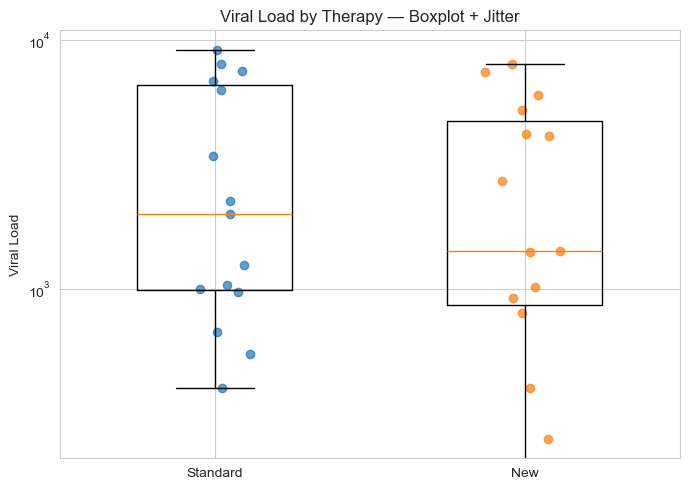

In [7]:
import matplotlib.pyplot as plt
import numpy as np

LOG_SCALE = True

# Figure 1: Boxplot + jitter
plt.figure(figsize=(7,5))
data_groups = [std, new]
positions = [1,2]
plt.boxplot(data_groups, positions=positions, widths=0.5, showfliers=True)
np.random.seed(0)
plt.scatter(np.random.normal(positions[0], 0.05, size=len(std)), std, alpha=0.7)
plt.scatter(np.random.normal(positions[1], 0.05, size=len(new)), new, alpha=0.7)
plt.xticks(positions, ['Standard', 'New'])
plt.ylabel('Viral Load')
plt.title('Viral Load by Therapy — Boxplot + Jitter')
if LOG_SCALE:
    plt.yscale('log')
plt.tight_layout()
plt.show()

## 6) Conclusion 结论
**English**: If p < 0.05 in the Mann–Whitney test, conclude that the new therapy differs from standard therapy in viral load; if the distribution (or median) is lower, it suggests better efficacy of the new therapy.

**中文**：若 Mann–Whitney 检验的 p < 0.05，则认为新疗法与标准疗法在病毒载量上存在显著差异；若新疗法的分布（或中位数）更低，则提示新疗法更有效。